# Convolutional Neural Network for Eye Diseases Classification

In this Jupyter Notebook, we explore 5 different convolutional neural network (CNN) models without transfer learning.  

The objective is to understand how varying network parameters such as the number of convolutional and fully connected layers, activation functions, and optimizers—affect model performance.  

Through experiments, we analyze the impact of architectural choices on accuracy, training dynamics, and generalization.

## Imports

In [63]:
import torch
import os
import torchvision
import opendatasets as od
import wandb
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [64]:
# Device selection to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Exploration

We download the eye diseases classification dataset and prepare the data for training, validation, and testing. Transformations include resizing images to 256x256 and normalization with ImageNet statistics.  

Splitting is done with 80% for training, 10% for validation, and 10% for testing. Custom subsets wrap the dataset to apply different transformations for train and test/validation sets.

In [65]:
od.download("https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification")


Skipping, found downloaded files in ".\eye-diseases-classification" (use force=True to force download)


In [66]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Using ImageNet statistics
    ])

transform_test_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [67]:
full_dataset = torchvision.datasets.ImageFolder(root='eye-diseases-classification/dataset')

### Custom Subset with Transforms

The default `Subset` does not apply transformations, so we wrap it in a custom class that applies transforms in the moment.

In [68]:
class TransformedSubset:
    def __init__(self, subset: Subset, transform: transforms.Compose):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index: int) -> tuple:
        img, label = self.subset[index]
        img = self.transform(img)
        return img, label
    
    def __len__(self) -> int:
        return len(self.subset)

### Dataset Splitting

We shuffle the indices using a fixed seed for reproducibility and split the dataset into training, validation, and test sets with proportions of 80%, 10%, and 10%, respectively.

In [69]:
np.random.seed(42)
index = np.arange(len(full_dataset))
np.random.shuffle(index)

train_percent = 0.8
test_val_percent = 0.1

train_index = int(train_percent * len(full_dataset))
test_val_index = int((train_percent + test_val_percent) * len(full_dataset))

dataset_train = TransformedSubset(Subset(full_dataset, index[:train_index]), transform_train)
dataset_val = TransformedSubset(Subset(full_dataset, index[train_index:test_val_index]), transform_test_val)
dataset_test = TransformedSubset(Subset(full_dataset, index[test_val_index:]), transform_test_val)

### DataLoader Creation

Finally, we create de DataLoaders for train, validation and test to generate batches during training and evaluation.

In [70]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

## Visualizate Images of Dataset

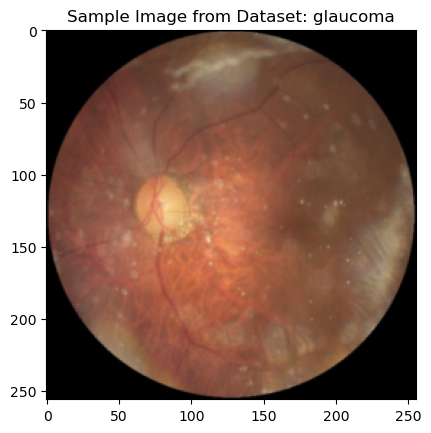

In [71]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
idx = random.randint(0, images.shape[0] - 1)
image = images[idx].numpy()
image = np.transpose(image, (1, 2, 0)) # For matplotlib we need to change the shape

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean 
image = np.clip(image, 0, 1)

plt.title("Sample Image from Dataset: {class_name}".format(class_name=full_dataset.classes[labels[idx].item()]))
plt.imshow(image)
plt.show()

## CNN Models


Below we present five convolutional neural network models for eye disease classification.  

All models use the same training and evaluation pipeline illustrated below. 

This pipeline includes training with early stopping, validation, testing, logging with W&B, and plotting loss and accuracy curves.

In [72]:
def train_validate(model, train_loader, val_loader, device, criterion, optimizer, epochs, early_stopping_criteria, save_path="models/model_default"):
    
    os.makedirs(save_path, exist_ok=True)
    best_model_file = os.path.join(save_path, "best_model.pth")
    
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    early_stopping_counter = 0
    
    total_train_loss = []
    total_val_loss = []
    total_train_accuracy = []
    total_val_accuracy = []

    for epoch in range(epochs):

        # TRAIN
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            

        train_loss = running_loss / len(train_loader)
        total_train_loss.append(train_loss)
        train_accuracy = 100 * train_correct / train_total
        total_train_accuracy.append(train_accuracy)

        # VALIDATION
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        total_val_loss.append(val_loss)
        val_accuracy = 100 * val_correct / val_total
        total_val_accuracy.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_file)

        if early_stopping_counter >= early_stopping_criteria:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        # Log in WanDB
        wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy
        })

    return total_train_loss, total_val_loss, total_train_accuracy, total_val_accuracy, best_model_file 

In [73]:
def test(model, test_loader, device, path_best_model):
    model.load_state_dict(torch.load(path_best_model))
    model.eval()

    test_correct = 0
    test_total = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_accuracy = 100 * test_correct / test_total
    print(f"Accuracy of the model on test images: {test_accuracy:.2f}%")

    wandb.log({"test_accuracy": test_accuracy})
    wandb.finish()

    return y_true, y_pred, test_accuracy

In [74]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, save_path=None):
    
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.title("Confusion Matrix")
    if save_path is not None:
        plt.savefig(os.path.join(save_path, "confusion_matrix.png"))
    plt.show()

In [75]:
def plot_metrics(total_train_loss, total_val_loss, total_train_accuracy, total_val_accuracy, save_path=None):

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

    # LOSS
    plt.figure()
    plt.plot(range(1, len(total_train_loss) + 1), total_train_loss, label='Training Loss')
    plt.plot(range(1, len(total_val_loss) + 1), total_val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xlim(1, len(total_train_loss))
    plt.xticks(range(1, len(total_train_loss) + 1, max(1, len(total_train_loss) // 10)))
    plt.title('Training and Validation Loss')
    plt.grid()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, "loss_graphic.png"), bbox_inches='tight')
    plt.show()

    # ACCURACY
    plt.figure()
    plt.plot(range(1, len(total_train_accuracy) + 1), total_train_accuracy, label='Training Accuracy')
    plt.plot(range(1, len(total_val_accuracy) + 1), total_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim(1, len(total_val_accuracy))
    plt.xticks(range(1, len(total_val_accuracy) + 1, max(1, len(total_val_accuracy) // 10)))
    plt.ylim(0, 100)
    plt.title('Training and Validation Accuracy')
    plt.grid()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, "accuracy_graphic.png"), bbox_inches='tight')
    plt.show()

### Model 1 – Deep CNN with Four Convolutional Blocks


This first architecture stacks four convolutional blocks with 3 × 3 kernels, batch normalisation, ReLU activation, and max pooling, progressively increasing the number of channels from 3 to 256 to capture tha maximun number of features, while attempting to make it as fast as possible. 

After flattening, two fully connected layers with ReLU and dropout (0.5) act as the classification head, and a final linear layer produces the classification for the four classes of eye diseases.

In [76]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(256, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        
        return x

#### Training and Evaluation of Model 1

##### Experiment setup

We train Model 1 using Adam with a learning rate of 0.001, mini-batches of size 32 and a maximum of 5 epochs, with early stopping = 15.

In [77]:
wandb.init(
    project="eye-disease-classification",
    name="model1_custom_cnn_4conv",
    config={
        "learning_rate": 0.001,
        "epochs": 5,
        "batch_size": 32,
        "architecture": "custom_cnn_4conv"
    }
)

run_dir = "models/model1"

In [78]:
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [79]:
total_train_loss, total_val_loss, total_train_acc, total_val_acc, best_model_file = train_validate(
    model, train_loader, val_loader, 
    device, criterion, optimizer, 
    epochs=5, early_stopping_criteria=15, save_path=run_dir
)

Epoch 1/5, Train Loss: 2.6762, Train Acc: 34.12%, Val Loss: 1.1380, Val Acc: 48.34%
Epoch 2/5, Train Loss: 1.1816, Train Acc: 43.37%, Val Loss: 0.9531, Val Acc: 52.13%
Epoch 3/5, Train Loss: 1.0347, Train Acc: 49.45%, Val Loss: 0.9355, Val Acc: 63.27%
Epoch 4/5, Train Loss: 1.0149, Train Acc: 52.56%, Val Loss: 0.8603, Val Acc: 47.16%
Epoch 5/5, Train Loss: 0.9818, Train Acc: 51.59%, Val Loss: 0.8607, Val Acc: 60.90%


In [80]:
y_true, y_pred, test_acc = test(model, test_loader, device, path_best_model=best_model_file)

Accuracy of the model on test images: 63.51%


epoch,▁▃▅▆█
test_accuracy,▁
train_accuracy,▁▅▇██
train_loss,█▂▁▁▁
val_accuracy,▂▃█▁▇
val_loss,█▃▃▁▁
epoch,5
test_accuracy,63.50711
train_accuracy,51.58613
train_loss,0.98179
val_accuracy,60.90047


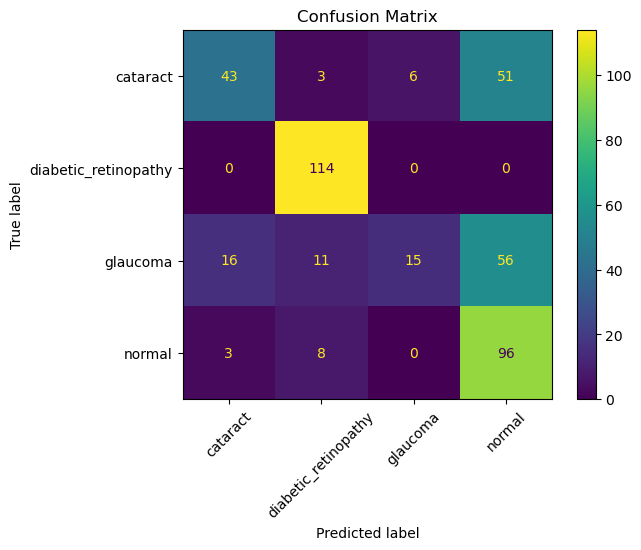

In [81]:
plot_confusion_matrix(y_true, y_pred, class_names=full_dataset.classes, save_path=run_dir)

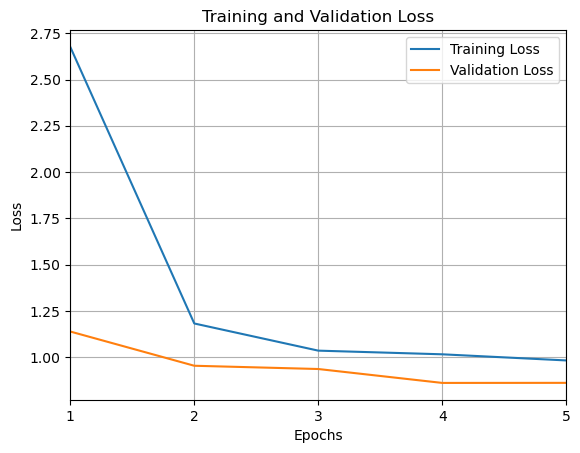

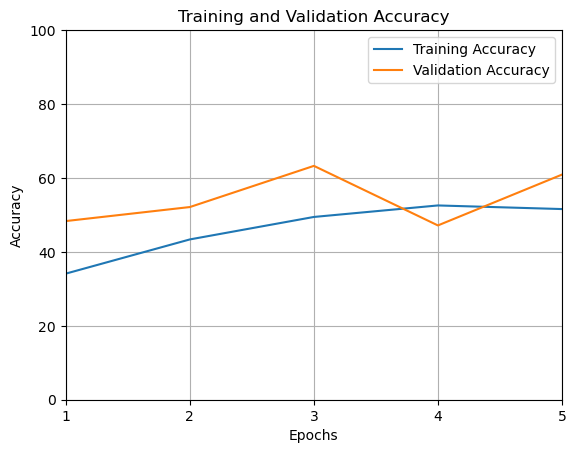

In [82]:
plot_metrics(total_train_loss, total_val_loss, total_train_acc, total_val_acc, save_path=run_dir)


### Adaptive Convolutional Network (Extra)

This adaptive CNN was implemented to experiment with highly configurable architectures. Instead of hard‑coding a specific layout, the network is built dynamically from lists that control the number of convolutional layers, their filters, and the fully connected layers.

In practice, this design didn't worked well, it became unstable for a lot of the architectures. The combination of dynamic layer construction, list‑based configurations and large input images made GPU memory usage harder to control.

In [83]:
class AdaptativeConvNet(nn.Module):
    def __init__(
        self, num_conv_layers, list_conv_filters, num_fc_layers, list_fc_neurons, in_channels=3,
        out_channels=4, activation_function=nn.ReLU, use_batchnorm_conv=True, use_batchnorm_fc=False,
        use_dropout_fc=False, use_dropout_conv=False, dropout_fc_rate=0.5, dropout_conv_rate=0.5, img_shape=(3, 256, 256)):
        
        super(AdaptativeConvNet, self).__init__()

        if num_conv_layers != len(list_conv_filters):
            raise ValueError(f"num_conv_layers = {num_conv_layers} pero list_conv_filters tiene {len(list_conv_filters)} elementos")
        if num_fc_layers != len(list_fc_neurons):
            raise ValueError(f"num_fc_layers = {num_fc_layers} pero list_fc_neurons tiene {len(list_fc_neurons)} elementos")

        conv_layers = []
        input_channels = in_channels
        for nf in list_conv_filters:
            conv_layers.append(nn.Conv2d(input_channels, nf, kernel_size=3, padding=1))
            if use_batchnorm_conv:
                conv_layers.append(nn.BatchNorm2d(nf))
            conv_layers.append(activation_function)
            if use_dropout_conv:
                conv_layers.append(nn.Dropout2d(dropout_conv_rate))
            input_channels = nf
        self.conv = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

        fc_input_dim = self.calc_fc_input_dim(img_shape)

        fc_layers = []
        prev_dim = fc_input_dim
        for fc_dim in list_fc_neurons:
            fc_layers.append(nn.Linear(prev_dim, fc_dim))
            if use_batchnorm_fc:
                fc_layers.append(nn.BatchNorm1d(fc_dim))
            fc_layers.append(activation_function)
            if use_dropout_fc:
                fc_layers.append(nn.Dropout(dropout_fc_rate))
            prev_dim = fc_dim
        fc_layers.append(nn.Linear(prev_dim, out_channels))
        self.fc = nn.Sequential(*fc_layers)

    def calc_fc_input_dim(self, img_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *img_shape)
            out = self.conv(dummy)
            out = out.flatten(1)
            return out.shape[1]

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x